## Connected to Google Drive

In [ ]:
# do not run when we import this package as module
if __name__ == '__main__':
  # Connect Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Load Base Modules

In [ ]:
if __name__ == '__main__':
  ## Load all ipynb files from Google Drive to Colab environment
  import os
  import shutil

  def find_and_copy_files(src_folder, dest_folder, file_extension):
    for foldername, subfolders, filenames in os.walk(src_folder):
        for filename in filenames:
            if filename.endswith(file_extension):
                src_file = os.path.join(foldername, filename)
                dest_file = os.path.join(dest_folder, filename)
                try:
                    shutil.copy2(src_file, dest_file)  # Use shutil.copy if you don't need metadata
                    print(f"Copied: {src_file} to {dest_file}")
                except Exception as e:
                    print(f"Error copying {src_file}: {e}")

In [ ]:
if __name__ == '__main__':
  src_folder = '/content/gdrive/MyDrive/OWR/source'
  dest_folder = '/content'
  file_extension = '.ipynb'

  # Call the function to find and copy files
  find_and_copy_files(src_folder, dest_folder, file_extension)

Copied: /content/gdrive/MyDrive/OWR/source/input_generator/owr_input_generator.ipynb to /content/owr_input_generator.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_classification.ipynb to /content/owr_preprocess_skew_CNN_classification.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_CNN_regression.ipynb to /content/owr_preprocess_skew_CNN_regression.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocess_skew_cv.ipynb to /content/owr_preprocess_skew_cv.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_pre_skew_cv_base.ipynb to /content/owr_pre_skew_cv_base.ipynb
Copied: /content/gdrive/MyDrive/OWR/source/owr_model/preprocessing/owr_preprocessing.ipynb to /content/owr_preprocessing.ipynb


In [ ]:
if __name__ == '__main__':
  !pip install import_ipynb
  import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00


## Libraries

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf /content/gdrive/MyDrive/OWR/log/

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import random
import datetime
import keras_tuner

import tensorflow as tf
from tensorflow import keras

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, InputLayer
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow.keras.applications.resnet_v2 import ResNet101V2
#from tensorflow.keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.applications.resnet_v2 import ResNet101V2, ResNet50V2

#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output
#from termcolor import colored

import warnings
warnings.filterwarnings('ignore')


# Import Colab Models
import owr_preprocessing as BPP

Using TensorFlow backend
importing Jupyter notebook from owr_preprocessing.ipynb


<ipython-input-8-c5dc5f58f060>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## Download Kaggle Dataset to G Drive

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

# Specify the Kaggle dataset URL
dataset_url = "https://www.kaggle.com/datasets/preatcher/standard-ocr-dataset"

# Download the dataset to the specified folder
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sachithgunawardane
Your Kaggle Key: ··········


100%|██████████| 46.2M/46.2M [00:00<00:00, 153MB/s]


In [ ]:
# Move dataset to G Drive
import shutil

source_path = "/content/standard-ocr-dataset"
destination_path = "/content/gdrive/MyDrive/OWR/data/standard-ocr-dataset"

#shutil.move(source_path, destination_path)

## Check Image Dimensions in Training, Validation and Test Dataset

In [ ]:
def random_image(img_path):
  # Initialize a list to store image paths
  image_paths = []

  # Use os.walk to search for image files in the root folder and its subfolders
  for folder_path, _, files in os.walk(img_path):
      for file in files:
          if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
              image_paths.append(os.path.join(folder_path, file))

  # Check if there are any image files in the folder
  if not image_paths:
    print("No image files found in the folder.")
    random_image = None
  else:
    # Choose a random image from the list
    random_image_file = random.choice(image_paths)

    # Open the random image
    random_image_path = os.path.join(img_path, random_image_file)
    random_image = Image.open(random_image_path)

  return random_image , len(image_paths)

In [ ]:
# Find minimum and maximum height and width among all images
def min_max_dimensions(img_path):
  # Initialize variables for minimum and maximum dimensions
  min_width, min_height = float('inf'), float('inf')
  max_width, max_height = 0, 0
  all_same_size = True

  # Use os.walk to traverse through the root folder and its subfolders
  for folder_path, _, files in os.walk(img_path):
      for file in files:
          if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
              image_path = os.path.join(folder_path, file)

              # Open the image
              try:
                image = Image.open(image_path)
              except Exception as e:
                continue

              # Get the dimensions of the image
              width, height = image.size

              # Update minimum and maximum dimensions
              min_width = min(min_width, width)
              min_height = min(min_height, height)
              max_width = max(max_width, width)
              max_height = max(max_height, height)

              if not (width == min_width and height == min_height):
                  all_same_size = False

  # Check if all images have the same dimensions
  if all_same_size:
      print("All images have the same dimensions:")
      print(f"Width: {min_width} pixels, Height: {min_height} pixels")
  else:
      print("Images have varying dimensions:")
      print(f"Minimum Width: {min_width} pixels, Minimum Height: {min_height} pixels")
      print(f"Maximum Width: {max_width} pixels, Maximum Height: {max_height} pixels")

In [ ]:
# Check for /content/standard-ocr-dataset/data
image_folder = '/content/standard-ocr-dataset/data/'
img, n_images = random_image(image_folder)

print(f'Image Size{np.array(img).shape}')
print(f'Number of Images: {n_images}')

min_max_dimensions(image_folder)

Image Size(41, 38)
Number of Images: 21636
Images have varying dimensions:
Minimum Width: 5 pixels, Minimum Height: 22 pixels
Maximum Width: 92 pixels, Maximum Height: 67 pixels


In [ ]:
# Check for /content/standard-ocr-dataset/data
random.seed(49)
image_folder = '/content/standard-ocr-dataset/data2/'
img, n_images = random_image(image_folder)

print(f'Image Size{np.array(img).shape}')
print(f'Number of Images: {n_images}')

min_max_dimensions(image_folder)

Image Size(39, 31)
Number of Images: 23870
Images have varying dimensions:
Minimum Width: 5 pixels, Minimum Height: 22 pixels
Maximum Width: 92 pixels, Maximum Height: 67 pixels


In [ ]:
# Check for /content/standard-ocr-dataset/data
image_folder = '/content/gdrive/MyDrive/OWR/data/tmpCharacterSegment'
img, n_images = random_image(image_folder)

print(f'Image Size{np.array(img).shape}')
print(f'Number of Images: {n_images}')

min_max_dimensions(image_folder)

Image Size(21, 5)
Number of Images: 16
Images have varying dimensions:
Minimum Width: 5 pixels, Minimum Height: 21 pixels
Maximum Width: 12 pixels, Maximum Height: 21 pixels


## Model Parameters

In [ ]:
# Dataset
training_directory = '/content/standard-ocr-dataset/data2/training_data'
testing_directory = '/content/standard-ocr-dataset/data2/testing_data'

# Parameters for image preprocessing
image_size = (40, 40)

batch_size = 32

## Data Visualization

In [ ]:
data_visual = image_dataset_from_directory(training_directory,
                                           labels='inferred',
                                           label_mode = 'categorical',
                                           image_size = image_size,
                                           batch_size = batch_size,
                                           shuffle = True )

Found 20628 files belonging to 36 classes.


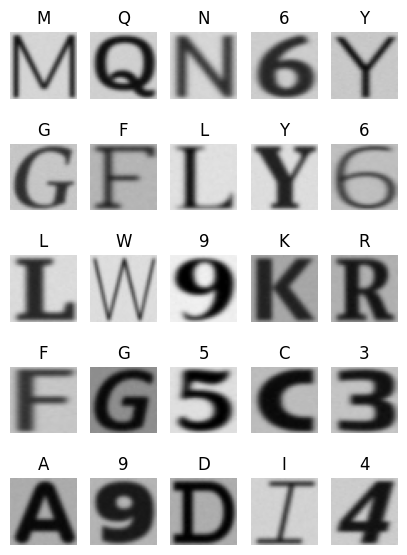

In [ ]:
classes = data_visual.class_names
plt.figure(figsize=(5,7))
for img, label in data_visual.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes[np.argmax(label[i])])
        plt.axis('off')


# from IPython.display import clear_output
clear_output()

In [ ]:
def preprocessing_fun(img):
  # Convert the NumPy array to an image using PIL
  image = np.uint8(img)

  #print(image.shape)

  # Turn to grayscale
  imgGray = BPP.set_grayscale(image)

  # Turn to Otsu Binarization
  imgAdaptive = BPP.set_Adaptive_Binarization(imgGray)

  image = cv2.cvtColor(imgAdaptive, cv2.COLOR_GRAY2RGB)

  noiseRemoved = cv2.fastNlMeansDenoisingColored(image, None, 3, 7, 21)



  return noiseRemoved

In [ ]:
# Preprocessing for training dataset
datagen = ImageDataGenerator(preprocessing_function= preprocessing_fun)

In [ ]:
train_dataset = datagen.flow_from_directory(training_directory,
                                            target_size=image_size,
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            class_mode='categorical'
                                            )


test_dataset = datagen.flow_from_directory(testing_directory,
                                           target_size=image_size,
                                           color_mode='rgb',
                                           batch_size=batch_size,
                                           shuffle=True,
                                           class_mode='categorical'
                                           )

Found 20628 images belonging to 36 classes.
Found 3242 images belonging to 36 classes.


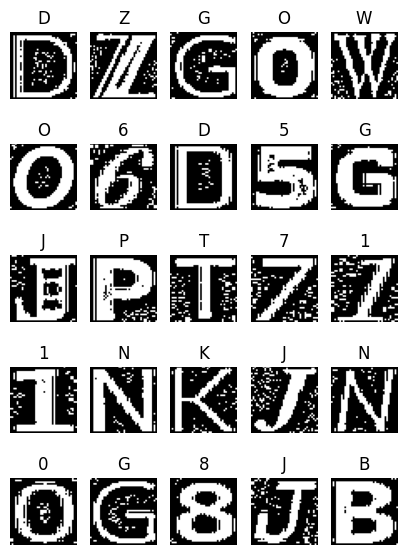

In [ ]:
# Plot a batch of preprocessed images (for visualization)
images, labels = next(train_dataset)
plt.figure(figsize=(5, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    #print(images[i].shape)
    plt.title(classes[np.argmax(labels[i])])
    plt.axis('off')
#plt.show()

# from IPython.display import clear_output
clear_output()

## Model Building

In [ ]:
image_shape_3d = image_size + (3,)

resnet101v2 = ResNet101V2(weights='imagenet', include_top=False, input_shape=image_shape_3d)
# make pre trained model into non trainable bcoz its takes much time
for layer in resnet101v2.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 1s 0us/step


In [ ]:
# Create model

def model_builder(hp):
  # Initialize the model in sequential
  model = Sequential()
  # add Resnet model
  model.add(resnet101v2)
  # flatten the model
  model.add(Flatten(name='Flatten') )
  hp_unit1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_unit1, activation='relu', name='FC_1'))
  model.add(Dropout(0.2))
  hp_unit2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
  model.add(Dense(units=hp_unit2, activation='relu', name='FC_2'))
  model.add(Dense(len(classes), activation='softmax', name='OutputLayer'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

  return model


In [ ]:
# Initialize the `HyperParameters` and set the values.
hp = keras_tuner.HyperParameters()
ocr_model = model_builder(hp)
ocr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2, 2, 2048)        42626560  
                                                                 
 Flatten (Flatten)           (None, 8192)              0         
                                                                 
 FC_1 (Dense)                (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 FC_2 (Dense)                (None, 32)                1056      
                                                                 
 OutputLayer (Dense)         (None, 36)                1188      
                                                                 
Total params: 42890980 (163.62 MB)
Trainable params: 264

In [ ]:
tensorboard_log_dir = "/content/gdrive/MyDrive/OWR/log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = "/content/gdrive/MyDrive/OWR/checkpoint/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

#Prepare call backs
EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=20, restore_best_weights=True)

#checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor = 'val_loss',
#                                                mode = 'min',save_best_only= True)


#my_callback=[tensorboard_callback,EarlyStop_callback,checkpoint]
my_callback=[tensorboard_callback]

In [ ]:
tuner = keras_tuner.RandomSearch(model_builder,
                                 max_trials=10,
                                 # Do not resume the previous search in the same directory.
                                 overwrite=True,
                                 objective="val_accuracy",
                                 seed=49,
                                 # Set a directory to store the intermediate results.
                                 directory="/tmp/tb",
                                 project_name="ocr_model"
)

In [ ]:
def build_datasets(hp):
  train_dataset = train_dataset
  validation_dataset = test_dataset
  return train_dataset, validation_dataset

In [ ]:
# Search for the best hyperparameters and pass the build_datasets function
tuner.search(train_dataset,
             epochs=5,
             validation_data=test_dataset,
             callbacks=my_callback)


Trial 2 Complete [00h 14m 31s]

Best val_accuracy So Far: None
Total elapsed time: 00h 29m 12s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |64                |units_1
512               |256               |units_2
0.01              |0.01              |learning_rate

Epoch 1/5
645/645 [==============================] - ETA: 0s - loss: 25.9320 - accuracy: 0.0265

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, i

RuntimeError: ignored

In [ ]:
%tensorboard

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-07 11:03:52.229224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 11:03:52.229352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 11:03:52.229393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 11:03:53.205372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for

In [ ]:
%tensorboard --logdir /content/gdrive/MyDrive/OWR/log/

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-07 11:03:07.561445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 11:03:07.561524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 11:03:07.561556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 11:03:08.543630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf